In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set()

# Start Reading Data

In [2]:
#read csv file
portfolio = pd.read_csv('https://goz39a.s3.eu-central-1.amazonaws.com/Portfolio.csv',parse_dates=True,index_col='T')


In [3]:
portfolio.head()

,DAX,NKY,SPX,SX5E,SX7E,SXAP,SXKP,PORTFOLIO
T,,,,,,,,
2014-10-08,-0.00437,-0.00520,0.00752,-0.00408,-0.00456,-0.00751,-0.00297,-0.00325
2014-10-09,0.00047,-0.00327,-0.00907,-0.00155,-0.00464,0.00024,-0.00558,-0.00562
2014-10-14,0.00179,-0.01046,-0.00653,0.00138,0.00075,0.01232,-0.00130,-0.01723
2014-10-15,-0.01265,0.00397,-0.00353,-0.01598,-0.02159,-0.01331,-0.01484,-0.00118
2014-10-16,0.00055,-0.00976,0.00006,-0.00270,-0.00929,0.00638,-0.00521,-0.00183


In [4]:
#the last column is the target
y = portfolio.values[:,-1]

#create the design / feature matrix
X = portfolio.values[:,0:-1]

futures_names = portfolio.columns[:-1]


# Calculate Regression

Set up the ridge regression (fit_intercept=True, in order to allow normalization to be true)

In [17]:
#setting up the ridge model
Alpha = 0.10
ridge_model = linear_model.Ridge(fit_intercept=True, alpha=Alpha,copy_X=True)
ridge_model.fit(X,y)
print('Coefficients for alphs:',str(Alpha))
print(ridge_model.coef_[:])

Coefficients for alphs: 0.1
[0.02681742 0.0249882  0.01979184 0.03000488 0.0368847  0.02495981
 0.02936001]


Setting up the OLS model

In [18]:
ols_model = linear_model.LinearRegression(fit_intercept=True)
ols_model.fit(X,y)

LinearRegression()

# Comparing Results

In [19]:
print('RSquared OLS')
print(ols_model.score(X,y))
print('RSquared Ridge')
print(ridge_model.score(X,y))

RSquared OLS
0.5721537153344336
RSquared Ridge
0.17843992310055234


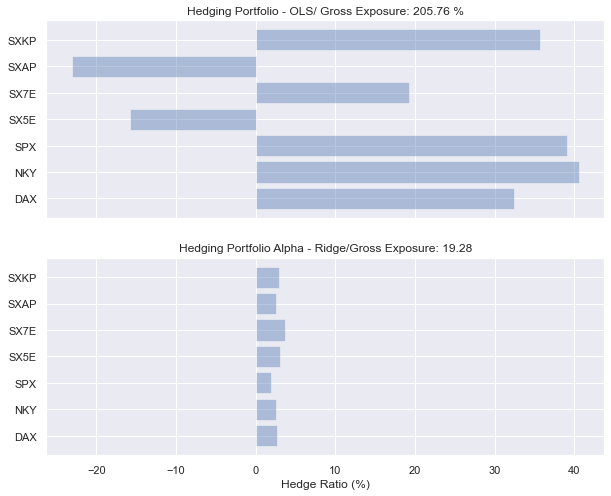

In [20]:
#OLS
fig, ax = plt.subplots(2,1,sharex=True,figsize=(10,8))


y_pos = np.arange(len(futures_names))
hedge_ols = ols_model.coef_
ax[0].barh(y=y_pos, width=hedge_ols*100, align='center', alpha=0.4)
ax[0].set_yticks(y_pos)
ax[0].set_yticklabels(futures_names)
ax[0].set_title('Hedging Portfolio - OLS/ Gross Exposure: {d:0.2f} %'.format(d=100*np.sum(np.abs(hedge_ols))))


#Ridge Regression
hedge_ridge = ridge_model.coef_
ax[1].barh(y=y_pos, width=hedge_ridge*100, align='center', alpha=0.4)
ax[1].set_yticks(y_pos)
ax[1].set_yticklabels(futures_names)
ax[1].set_xlabel('Hedge Ratio (%)')
ax[1].set_title('Hedging Portfolio Alpha - Ridge/Gross Exposure: {d:0.2f}'.format(d=100*np.sum(np.abs(hedge_ridge))));

# Study the impact of the ridge regression on the weights

For different values of Alpha

In [9]:
alpha = np.power(10,np.arange(-2,0,0.005))

In [10]:
weights = np.zeros((len(alpha),len(futures_names)),dtype=float)

In [11]:
for i in np.arange(0,len(alpha)):
    ridge_model = linear_model.Ridge(fit_intercept=True, 
                                     alpha=alpha[i],
                                     copy_X=True)
    ridge_model.fit(X,y)
    weights[i,:]= ridge_model.coef_
    

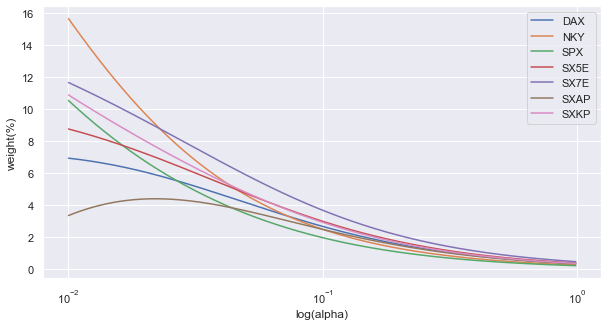

In [12]:
plt.figure(figsize=(10,5))    
for i in np.arange(0,len(futures_names)):
    plt.semilogx(alpha[:],weights[:,i]*100,label=futures_names[i])

plt.xlabel('log(alpha)')
plt.ylabel('weight(%)')
plt.legend(loc="upper right");
    

# Using cross validation to find the optimal value of the ridge factor.

In [13]:
# use cross validation using 10 Fold cross validation
Ridge=linear_model.RidgeCV(alphas=alpha,fit_intercept=True,cv=10)
Ridge.fit(X,y)
print('Optimal Value for Alpha:{v:0.4f}'.format(v=Ridge.alpha_))
print(Ridge.coef_)

Optimal Value for Alpha:0.0100
[0.06939093 0.15644274 0.10535921 0.08760943 0.11657861 0.03362317
 0.10881933]


In [14]:
print('Gross Exposure',np.round(100*np.sum(np.abs(Ridge.coef_)),2))

Gross Exposure 67.78
